<a href="https://colab.research.google.com/github/mosdef-hub/CECAM-MoSDeF-Workshop/blob/main/polymer_workflow/hoomd-organics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Orientation, Installation, & Setup
## Learning objectives
This notebook provides interactive examples that will assist learners in using MoSDeF tools to:
* Initialize complex macromolecules for molecular simulation.
* Demonstrate how to run HOOMD-Blue simulations with these molecules.
* Use and inspect forcefields.
* Generate coarse-grained representations and run simplified models.

## Software stack setup
After running the cell below the kernel will restart -- This is necessary for conda dependencies, but you'll need to wait for that kernel restart before running the second cell.

## Interface notes
There are two types of output in these Colab notebooks that can be a little tricky:

1. If the output is very long, for example from the mamba command in the second cell, scrolling past the output can feel onerous. In this case, scrolling up and down in the narrow grey area between the sidebar menu and the cells can help you navigate.

2. If the output is a visualization of a molecule or simulation configuration, scrolling up or down will zoom in or out if the cursor is over the visualization. In these cases, take some care to scroll outside of the visualization.

In [1]:
!pip install -q condacolab
!git clone --single-branch --branch cecam https://github.com/cmelab/hoomd-organics
import condacolab
condacolab.install()

Cloning into 'hoomd-organics'...
remote: Enumerating objects: 2811, done.
remote: Counting objects: 100% (912/912), done.
remote: Compressing objects: 100% (279/279), done.
remote: Total 2811 (delta 692), reused 633 (delta 633), pack-reused 1899
Receiving objects: 100% (2811/2811), 1.03 MiB | 11.22 MiB/s, done.
Resolving deltas: 100% (1932/1932), done.
⏬ Downloading https://github.com/conda-forge/miniforge/releases/download/23.1.0-1/Mambaforge-23.1.0-1-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:17
🔁 Restarting kernel...


It will take about 2-3 minutes to install the python dependencies after the kernel restarts. Once the kernel does restart, you can run this cell right away. This cell and the previous one only need to be run once each, and running either one a second time can cause some confusions.

In [1]:
import os
os.chdir("hoomd-organics")
!mamba env update -n base -f environment-cpu.yml
!python -m pip install -e .
import warnings
warnings.filterwarnings('ignore')

[+] 0.0s
[+] 0.1s
conda-forge/linux-64  ⣾  
conda-forge/noarch    ⣾  [+] 0.2s
conda-forge/linux-64  ⣾  
conda-forge/noarch    ⣾  [+] 0.3s
conda-forge/linux-64  ⣾  
conda-forge/noarch    ⣾  [+] 0.4s
conda-forge/linux-64  ⣾  
conda-forge/noarch    ⣾  [+] 0.5s
conda-forge/linux-64  ⣾  
conda-forge/noarch    ⣾  [+] 0.6s
conda-forge/linux-64  ⣾  
conda-forge/noarch    ⣾  [+] 0.7s
conda-forge/linux-64  ⣾  
conda-forge/noarch    ⣾  [+] 0.8s
conda-forge/linux-64  ⣾  
conda-forge/noarch    ⣾  [+] 0.9s
conda-forge/linux-64  ⣾  
conda-forge/noarch    ⣾  [+] 1.0s
conda-forge/linux-64  ⣾  
conda-forge/noarch    ⣾  [+] 1.1s
conda-forge/linux-64  ⣾  
conda-forge/noarch    ⣾  [+] 1.2s
conda-forge/linux-64  ⣾  
conda-forge/noarch    ⣾  [+] 1.3s
conda-forge/linux-64  ⣾  
conda-forge/noarch    ⣾  [+] 1.4s
conda-forge/linux-64  ⣾  
conda-forge/noarch    ⣾  [+] 1.5s
conda-forge/linux-64  ⣾  
conda-forge/noarch    ⣾  [+] 1.6s
conda-forge/linux-64  ⣾  
conda-forge/noarch    ⣾  [+] 1.7s
conda-forge/linux-64  


#1.  HOOMD simulations from start to finish with MoSDeF Tools
## Overview:
We'll see how to run simulations of poly(phenylene sulfide) (PPS) molecules using the `hoomd-organics`, a package of MoSDeF tools for initializing and performing common MD simulations of organic molecules. This uses the [`HOOMD-blue`](https://hoomd-blue.readthedocs.io/en/v4.1.0/) simulation engine.



## 1.1 Initialization, parameterization, and simulation

First, let's see everything in one block:

With just a couple of imports and a few lines of code, we are able to initialize 30 8-mers of PPS, randomly pack them into a volume, perform a simulation in the NVT ensemble, and peek at the final configuration.

Depending on your colab node utilization, this may take anywhere from 1-7 minutes.

/usr/local/lib/python3.10/site-packages/mbuild/recipes/__init__.py:13: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  entry_points = metadata.entry_points()["mbuild.plugins"]
*Warning*: charge.pppm: RMS error of 0.72302 is probably too high! 0.72302 0.72295


Initializing simulation state from a snapshot.
Step 100 of 1000; TPS: 33.61; ETA: 0.4 minutes
Step 200 of 1000; TPS: 39.71; ETA: 0.3 minutes
Step 300 of 1000; TPS: 36.95; ETA: 0.3 minutes
Step 400 of 1000; TPS: 32.44; ETA: 0.3 minutes
Step 500 of 1000; TPS: 30.2; ETA: 0.3 minutes
Step 600 of 1000; TPS: 29.33; ETA: 0.2 minutes
Step 700 of 1000; TPS: 30.08; ETA: 0.2 minutes
Step 800 of 1000; TPS: 30.22; ETA: 0.1 minutes
Step 900 of 1000; TPS: 28.71; ETA: 0.1 minutes
Step 1000 of 1000; TPS: 23.17; ETA: 0.0 minutes
Step 99 of 1000; TPS: 13.55; ETA: 1.1 minutes
Step 199 of 1000; TPS: 10.69; ETA: 1.2 minutes
Step 299 of 1000; TPS: 10.95; ETA: 1.1 minutes
Step 399 of 1000; TPS: 11.09; ETA: 0.9 minutes
Step 499 of 1000; TPS: 10.54; ETA: 0.8 minutes
Step 599 of 1000; TPS: 11.05; ETA: 0.6 minutes
Step 699 of 1000; TPS: 10.49; ETA: 0.5 minutes
Step 799 of 1000; TPS: 10.8; ETA: 0.3 minutes
Step 899 of 1000; TPS: 10.81; ETA: 0.2 minutes
Step 999 of 1000; TPS: 10.67; ETA: 0.0 minutes


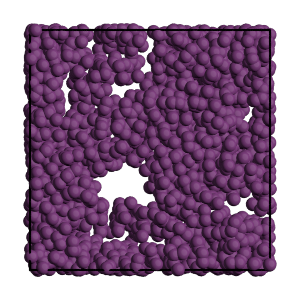

In [2]:
from hoomd_organics.library import PPS, OPLS_AA_PPS
from hoomd_organics import Pack, Simulation
from cmeutils.visualize import FresnelGSD

molecules = PPS(num_mols=30, lengths=8)
system = Pack(molecules=molecules, force_field=OPLS_AA_PPS(), density=0.8, r_cut=2.5, auto_scale=True, scale_charges=True, packing_expand_factor=5)
pps_ff = system.hoomd_forcefield
sim = Simulation(initial_state=system.hoomd_snapshot, forcefield=pps_ff, gsd_write_freq=100, log_write_freq=100, gsd_file_name="pps.gsd")
sim.run_update_volume(n_steps=1000, period=1, kT=1, tau_kt=1, final_box_lengths=system.target_box)
sim.run_NVT(n_steps=1000, kT=1.0, tau_kt=0.01)
viz = FresnelGSD("pps.gsd")
viz.frame = -1 # python convention for last element
viz.view()


In the above example, a lot of functionality is provided by two key imports: `PPS`, `and OPLS_AA_PPS`. `PPS()` uses `mBuild` tools to initialize PPS chemistries specificially, and `OPLS_AA_PPS` is an instance of a `foyer.Forcefield` that provides the subset of parameters from OPLS_AA needed by PPS specifically.

In the next sections we'll explore each of these components in some more depth.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


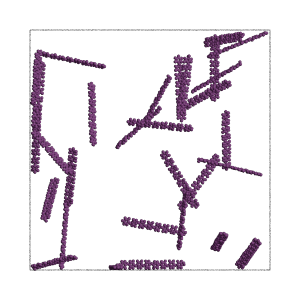

In [ ]:
#Can play around visualizing other frames here
viz.frame = 2 #Here the frames run from 0-20: 1 initial configuration, 10 frames from the volume shrink, and 10 frames from the NVT run.
viz.view()

# 2. Defining Molecules

What other ways can we initialize molecules in simulation volumes?

Above, we used the `PPS` class, a subclass of the `hoomd-organics` `Molecule` class. This class includes all the necessary information about the PPS molecule, including the monomer structure and how the monomers bond to create a chain. All we needed was to specify is the polymer length and how many polymer chains we want to create in the `PPS()` constructor.

You can also define your own molecule(s):
- Using the SMILES string of the molecule
- Using the molecule file (accepted formats are: `.mol2` and `.sdf`)
- Using a [`mbuild`](https://mbuild.mosdef.org/en/stable/) compound or a [`gmso`](https://gmso.mosdef.org/en/stable/) topology
- By defining your own subclass of `Molecule`, such as [PPS](https://github.com/cmelab/hoomd-organics/blob/e709be850cc2e818f817243bc82e5414465d0e6b/hoomd_organics/library/polymers.py#L35).

## Activity 2.1

Use the template code below to initialize some copies of a molecule using SMILES strings. Put your blue sticky note up on your laptop when you've been able to explore a bit. Put up your pink sticky note or file an issue at [github](https://github.com/cmelab/hoomd-organics/issues) if you run into any problems!

<details>
<summary>Hint: Click here if you are stuck.</summary>
Replace "YOUR_SMILES_HERE" with a valid smiles string such as "c1cc(C(O)=O)ccc1" to initialize `num_mols` instances of that molecule.
</details>


In [ ]:
# example of loading molecule(s) using the SMILES string and visualizing it
from hoomd_organics import Molecule
benzoic_acid_mol = Molecule(num_mols=20, smiles="YOUR_SMILES_HERE") #
benzoic_acid_mol.molecules[0].visualize()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

## 2.2 Initializing molecules from `mol2` or `sdf` files


In [ ]:
# example of loading a molecule using a mol2 file
# If you have another mol2 or sdf file accessible over the web, you can wget it as below:
#!wget https://raw.githubusercontent.com/cmelab/hoomd-organics/main/hoomd_organics/assets/molecule_files/IPH.mol2
phenol_mol = Molecule(num_mols=20, file="hoomd_organics/assets/molecule_files/IPH.mol2")
phenol_mol.molecules[0].visualize()

## 2.3:  Initializing from a [`mbuild`](https://mbuild.mosdef.org/en/stable/) compound or a [`gmso`](https://gmso.mosdef.org/en/stable/) topology

In [ ]:
# example of loading a molecule from mbuild compound or gmso topology
import mbuild as mb
mb_compound = mb.load("c1ccccc1", smiles=True) #let's doublecheck benzene
gmso_top = mb_compound.to_gmso()
benzene_mol = Molecule(num_mols=20, compound=mb_compound)
benzene_mol = Molecule(num_mols=20, compound=gmso_top)

# 3. Defining and inspecting systems

How did we use the molecules created above to initialize a simulation volume that was then used to run an MD simulation?

The `Pack` class, which is a subclass of the `System` class, is used to pack a box of PPS molecules given a density. The `System` class provides code to create the simulation volume and fill it with molecules, applies the force-field (if provided) to the system and creates the initial state of the system in the form a `gsd` snapshot.

If the force-field is provided, `Pack` also gets the list of forces that defines the bonded and non-bonded interactions between the particles.

In this example, we passed the molecules object created in section 1.1 to pack a box with density=0.8.
Let's visualize this initial configuration:

In [ ]:
system.system.visualize()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

## 3.1 Inspecting forces

Let's see what values of sigma and epsilon were used to parameterize the Lennard-Jones potential in our simulation.

To get this information, we access forcefield information, which we stored in `pps_ff` earlier, calling `system.hoomd_forcefield`.

By accessing `pps_ff` we can see which forcefield components are stored in which elements of the list:

In [ ]:
pps_ff

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Activity 3.1
and then we can view the parameters (`params`) of the LJ pair forces as a dictionary:

In [ ]:
dict(pps_ff[INDEX].params)

#4. Defining your own Forcefield
`hoomd-organics` package has a list of pre-defined force-fields that can be used to initialize the system. If you have the `xml` file of the forcefield, you can use the `FF_from_file` class from `hoomd_organics.library` to create a force-field object.
You can also define your own forcefield by creating a subclass of the `foyer.Forcefield` class.


In [ ]:
from hoomd_organics.library import FF_from_file
benzene_ff = FF_from_file(xml_file="hoomd_organics/assets/forcefields/benzene_opls.xml")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Checkout `hoomd_organics/library/forcefields.py` for more some examples of defining a forcefield using a subclass of `foyer.Forcefield` for specific molecules.

# 5. Defining your own System


`hoomd_organics` package has two methods of filling the box built in the `System` class: `Pack` and `Lattice`. We used `Pack` above, which leverages an `mBuild` interface to packmol. `Lattice` is demonstrated below:

In [ ]:
# example of defining a system using the Lattice method

from hoomd_organics import Lattice
from hoomd_organics.library import OPLS_AA

benzene_mol = Molecule(num_mols=32, smiles="c1ccccc1")

lattice = Lattice(
            molecules=[benzene_mol],
            force_field=OPLS_AA(),
            density=1.0,
            r_cut=2.5,
            x=1,
            y=1,
            n=4,
            auto_scale=True
        )
lattice.system.visualize()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

#6 Systems with multiple molecule types

You can also define your own method of filling the box by creating a subclass of the `System` class. For example, one method of filling a box with two types of molecule is creating alternate layers of each molecule type.

The system class can take a list of different molecule types along with different forcefields. If all molecule types use the same forcefield, then you only need to pass the forcefield once.

In [ ]:
#!wget https://github.com/cmelab/hoomd-organics/raw/main/hoomd_organics/assets/forcefields/dimethylether_opls.xml
from hoomd_organics.library import OPLS_AA_DIMETHYLETHER
dimethylether_mol = Molecule(num_mols=20, smiles="COC")
pps_mol = PPS(num_mols=10, lengths=4)
multi_type_system = Pack(
    molecules=[dimethylether_mol, pps_mol], #specify numbers of molecules in constructors above
    density=0.8,
    r_cut=2.5,
    force_field=[OPLS_AA_DIMETHYLETHER(), OPLS_AA_PPS()],
    auto_scale=True,
)
multi_type_system.system.visualize()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#7. Coarse-graining

In the following example, we'll demonstrate how to generate a coarse-grained representation of a molecule, apply it to a simulation volume, define a forcefield for that coarse representation, and run a HOOMD simulation with it.

In [3]:
from hoomd_organics.base import Pack, Simulation
from hoomd_organics.library import PPS, BeadSpring
pps_mol = PPS(num_mols=300, lengths=6)
pps_mol.molecules[0].visualize()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [4]:
pps_mol.coarse_grain(beads={"A": "c1ccc(S)cc1"})
pps_mol.molecules[0].visualize()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [5]:
cg_system = Pack(molecules=pps_mol, density=0.5, r_cut=2.5, auto_scale=False)
cg_system.system.visualize()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [6]:


ff = BeadSpring(
    r_cut=2.5,
    beads={"A": dict(epsilon=1.0, sigma=1.0),},
    bonds={"A-A": dict(r0=1.1, k=300),},
    angles={"A-A-A": dict(t0=2.0, k=200)},
    dihedrals={"A-A-A-A": dict(phi0=0.0, k=100, d=-1, n=1)},
)
cg_sim = Simulation(initial_state=cg_system.hoomd_snapshot, forcefield=ff.hoomd_forcefield, gsd_write_freq=100, log_write_freq=100, gsd_file_name = "cg.gsd")
cg_sim.run_update_volume(n_steps=1000, period=1, kT=1, tau_kt=1,  final_box_lengths=cg_system.target_box)
print(cg_system.hoomd_snapshot.particles.types)
cg_sim.run_NVT(n_steps=1e3, kT=1.2, tau_kt=1)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Initializing simulation state from a snapshot.
Step 100 of 1000; TPS: 64.86; ETA: 0.2 minutes
Step 200 of 1000; TPS: 113.86; ETA: 0.1 minutes
Step 300 of 1000; TPS: 149.64; ETA: 0.1 minutes
Step 400 of 1000; TPS: 176.23; ETA: 0.1 minutes
Step 500 of 1000; TPS: 197.76; ETA: 0.0 minutes
Step 600 of 1000; TPS: 212.82; ETA: 0.0 minutes
Step 700 of 1000; TPS: 226.69; ETA: 0.0 minutes
Step 800 of 1000; TPS: 244.67; ETA: 0.0 minutes
Step 900 of 1000; TPS: 260.36; ETA: 0.0 minutes
Step 1000 of 1000; TPS: 261.83; ETA: 0.0 minutes
['A']
Step 99 of 1000; TPS: 176.99; ETA: 0.1 minutes
Step 199 of 1000; TPS: 189.06; ETA: 0.1 minutes
Step 299 of 1000; TPS: 221.52; ETA: 0.1 minutes
Step 399 of 1000; TPS: 237.36; ETA: 0.0 minutes
Step 499 of 1000; TPS: 249.01; ETA: 0.0 minutes
Step 599 of 1000; TPS: 267.55; ETA: 0.0 minutes
Step 699 of 1000; TPS: 277.62; ETA: 0.0 minutes
Step 799 of 1000; TPS: 287.84; ETA: 0.0 minutes
Step 899 of 1000; TPS: 305.67; ETA: 0.0 minutes
Step 999 of 1000; TPS: 321.31; ETA: 

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


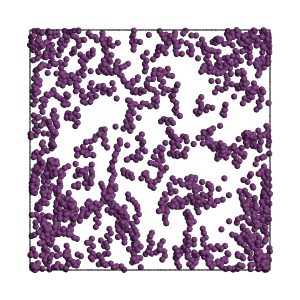

In [7]:
cg_viz = FresnelGSD("cg.gsd")
cg_viz.frame = 20
cg_viz.view()